<a href="https://colab.research.google.com/github/pritesh604/AVMLA_Project_IAE/blob/master/Data_loader(nuscenes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone git@github.com:pritesh604/Radr_Camera_fusion.gitn.git

Cloning into 'Radr_Camera_fusion.gitn'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [2]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2021-07-26 07:20:52--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.227.53.99, 13.227.53.44, 13.227.53.38, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.227.53.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  36.1MB/s    in 74s     

2021-07-26 07:22:06 (54.1 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [3]:
from nuscenes.utils.data_classes import RadarPointCloud, Box
from nuscenes.utils.geometry_utils import box_in_image, view_points, BoxVisibility, points_in_box
import numpy as np

from nuscenes.utils.data_classes import PointCloud
import matplotlib.pyplot as plt
import sys
import os
import os.path as osp
from PIL import Image
from pyquaternion import Quaternion

In [4]:
channels = ['RADAR_FRONT','CAM_FRONT']


# **CAMERA DATA**

In [5]:

def create_annotations(self, sample_token, sensor_channels):
        """
        Create annotations for the the given sample token.
        1 bounding box vector contains:
        :param sample_token: the sample_token to get the annotation for
        :param sensor_channels: list of channels for cropping the labels, e.g. ['CAM_FRONT', 'RADAR_FRONT']
            This works only for CAMERA atm
        :returns: 
            annotations dictionary:
            {
                'labels': [] # <list of n int>  
                'bboxes': [] # <list of n x 4 float> [xmin, ymin, xmax, ymax]
                'distances': [] # <list of n float>  Center of box given as x, y, z.
                'visibilities': [] # <list of n float>  Visibility of annotated object
            }
        """

        if any([s for s in sensor_channels if 'RADAR' in s]):
            print("[WARNING] Cropping to RADAR is not supported atm")
            sensor_channels = [c for c in sensor_channels if 'CAM' in sensor_channels]

        sample = self.nusc.get('sample', sample_token)
        annotations_count = 0
        annotations = {
            'labels': [], # <list of n int>  
            'bboxes': [], # <list of n x 4 float> [xmin, ymin, xmax, ymax]
            'distances': [], # <list of n float>  Center of box given as x, y, z.
            'visibilities': [],
            'num_radar_pts':[] #<list of n int>  number of radar points that cover that annotation
            }

        # Camera parameters
        for selected_sensor_channel in sensor_channels:
            sd_rec = self.nusc.get('sample_data', sample['data'][selected_sensor_channel])

            # Create Boxes:
            _, boxes, camera_intrinsic = self.nusc.get_sample_data(sd_rec['token'], box_vis_level=BoxVisibility.ANY)
            imsize_src = (sd_rec['width'], sd_rec['height']) # nuscenes has (width, height) convention
            
            bbox_resize = [ 1. / sd_rec['height'], 1. / sd_rec['width'] ]
            if not self.normalize_bbox:
                bbox_resize[0] *= float(self.image_min_side)
                bbox_resize[1] *= float(self.image_max_side)

            # Create labels for all boxes that are visible
            for box in boxes:

                # Add labels to boxes 
                if box.name in self.classes:
                    box.label = self.classes[box.name]
                    # Check if box is visible and transform box to 1D vector
                    if box_in_image(box=box, intrinsic=camera_intrinsic, imsize=imsize_src, vis_level=BoxVisibility.ANY):
                        
                        ## Points in box method for annotation filterS
                        # check if bounding box has an according radar point
                        if self.only_radar_annotated == 2:

                            pcs, times = RadarPointCloud.from_file_multisweep(self.nusc, sample, self.radar_sensors[0], \
                                selected_sensor_channel, nsweeps=self.n_sweeps, min_distance=0.0, merge=False)

                            #for pc in pcs:
                            pc.points = radar.enrich_radar_data(pc.points)    

                            if len(pcs) > 0:
                                radar_sample = np.concatenate([pc.points for pc in pcs], axis=-1)
                            else:
                                print("[WARNING] only_radar_annotated=2 and sweeps=0 removes all annotations")
                                radar_sample = np.zeros(shape=(len(channel_map), 0))
                            radar_sample = radar_sample.astype(dtype=np.float32)

                            mask = points_in_box(box, radar_sample[0:3,:])
                            if True not in mask:
                                continue 


                        # If visible, we create the corresponding label
                        box2d = box.box2d(camera_intrinsic) # returns [xmin, ymin, xmax, ymax]
                        box2d[0] *= bbox_resize[1]
                        box2d[1] *= bbox_resize[0]
                        box2d[2] *= bbox_resize[1]
                        box2d[3] *= bbox_resize[0]

                        annotations['bboxes'].insert(annotations_count, box2d)
                        annotations['labels'].insert(annotations_count, box.label)
                        annotations['num_radar_pts'].insert(annotations_count, self.nusc.get('sample_annotation', box.token)['num_radar_pts'])

                        distance =  (box.center[0]**2 + box.center[1]**2 + box.center[2]**2)**0.5
                        annotations['distances'].insert(annotations_count, distance)
                        annotations['visibilities'].insert(annotations_count, int(self.nusc.get('sample_annotation', box.token)['visibility_token']))
                        annotations_count += 1
                else:
                    # The current name has been ignored
                    pass

        annotations['labels'] = np.array(annotations['labels'])
        annotations['bboxes'] = np.array(annotations['bboxes'])
        annotations['distances'] = np.array(annotations['distances'])
        annotations['num_radar_pts'] = np.array(annotations['num_radar_pts'])
        annotations['visibilities'] = np.array(annotations['visibilities'])

        # num_radar_pts mathod for annotation filter
        if self.only_radar_annotated == 1:

            anns_to_keep = np.where(annotations['num_radar_pts'])[0]

            for key in annotations:
                annotations[key] = annotations[key][anns_to_keep]

        return annotations

In [6]:
from nuscenes.nuscenes import NuScenes 
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.403 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [7]:
my_scene = nusc.scene[0]
my_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample',my_sample_token)


In [8]:
cam_data = nusc.get('sample_data',my_sample['data']['CAM_FRONT'])
_,boxes,camera_intrinsic = nusc.get_sample_data(cam_data['token'],box_vis_level = BoxVisibility.ANY)               
imsize_src = (cam_data['width'], cam_data['height'])

In [9]:
bbox_resize = [ 1. / cam_data['height'], 1. / cam_data['width'] ]
image_min_side = 900
image_max_side = 1000
normalize_bbox = False

if not normalize_bbox:
                bbox_resize[0] *= float(image_min_side)
                bbox_resize[1] *= float(image_max_side)

In [119]:
classes = ['pedestrian', 'car', 'bicycle']
search_classes = ['human.pedestrian.adult','vehicle.car','vehicle.bicycle']

In [120]:
def enrich_radar_data(radar_data):
    data_collections=[]
    """
    This function adds additional data to the given radar data
    
    :param radar_data: The source data which are used to calculate additional metadata
        Semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0
    :returns enriched_radar_data:
            [0]: x
            [1]: y
            [2]: z
            [3]: dyn_prop
            [4]: id
            [5]: rcs
            [6]: vx
            [7]: vy
            [8]: vx_comp
            [9]: vy_comp
            [10]: is_quality_valid
            [11]: ambig_state
            [12]: x_rms
            [13]: y_rms
            [14]: invalid_state
            [15]: pdh0
            [16]: vx_rms
            [17]: vy_rms
            [18]: distance
            [19]: azimuth
            [20]: vrad_comp
    """
     

    # Adding distance
    # Calculate distance
    assert radar_data.shape[0] == 18, "Channel count mismatch."

    # Adding distance
    # Calculate distance
    dist = np.sqrt(radar_data[0,:]**2 + radar_data[1,:]**2)
    dist = np.expand_dims(dist, axis=0)

    # calculate the azimuth values
    azimuth = np.arctan2(radar_data[1,:], radar_data[0,:]) 
    azimuth = np.expand_dims(azimuth, axis=0)

    # Calculate vrad comp
    radial = np.array([radar_data[0,:], radar_data[1,:]]) # Calculate the distance vector
    radial = radial / np.linalg.norm(radial, axis=0, keepdims=True)# Normalize these vectors
    v = np.array([radar_data[8,:], radar_data[9,:]]) # Create the speed vector
    vrad_comp = np.sum(v*radial, axis=0, keepdims=True) # Project the speed component onto this vector

    data_collections = [
        radar_data,
        dist,
        azimuth,
        vrad_comp
    ]

    enriched_radar_data = np.concatenate(data_collections, axis=0)

    return enriched_radar_data

In [121]:
only_radar_annotated = 2

In [122]:
for box in boxes:
  print(box.name)

human.pedestrian.adult
human.pedestrian.adult
vehicle.car
vehicle.bicycle
human.pedestrian.adult
human.pedestrian.adult
movable_object.barrier
movable_object.barrier
vehicle.car
human.pedestrian.adult
vehicle.truck
vehicle.car
human.pedestrian.adult
movable_object.barrier
movable_object.barrier
movable_object.barrier
movable_object.barrier
movable_object.barrier
human.pedestrian.adult
human.pedestrian.adult
movable_object.barrier
human.pedestrian.adult
movable_object.barrier
vehicle.car
movable_object.barrier
movable_object.barrier
vehicle.car
movable_object.barrier
movable_object.barrier
vehicle.construction
movable_object.barrier
vehicle.car
human.pedestrian.adult
human.pedestrian.adult
human.pedestrian.adult
human.pedestrian.adult
human.pedestrian.adult
vehicle.truck
human.pedestrian.adult
human.pedestrian.adult
human.pedestrian.adult
movable_object.pushable_pullable
movable_object.barrier
movable_object.barrier
vehicle.car
movable_object.barrier
movable_object.barrier
movable_objec

In [123]:
annotations = {
            'labels': [], # <list of n int>  
            'bboxes': [], # <list of n x 4 float> [xmin, ymin, xmax, ymax]
            'distances': [], # <list of n float>  Center of box given as x, y, z.
            'visibilities': [],
            'num_radar_pts':[] }#<list of n int>  number of radar points that cover that annotation

annotations_count = 0            

for box in boxes:
  
  for i in range(len(classes)):
    if search_classes[i] == str(box.name):
      
        box.label = str(classes[i])
        if box_in_image(box=box, intrinsic=camera_intrinsic, imsize=imsize_src, vis_level=BoxVisibility.ANY):
                       
                                
                        
                        ## Points in box method for annotation filterS
                        # check if bounding box has an according radar point
                        if only_radar_annotated == 2:
                            n_sweeps = 2

                            pcs, times = RadarPointCloud.from_file_multisweep(nusc, my_sample,'RADAR_FRONT',ref_chan= 'CAM_FRONT', nsweeps=n_sweeps, min_distance=0.0)
                            #enriched_data = np.zeros((21,pcs.points.shape[1]))
                            #for i  in range(pcs.points.shape[1]):
                              #enriched_data[:,i] = enrich_radar_data(pcs.points[:,i])  
                            data = pcs.points.astype(float)
                            enriched_data= enrich_radar_data(data)


                            if len(pcs.points) > 0:
                                radar_sample = enriched_data
                            else:
                                print("[WARNING] only_radar_annotated=2 and sweeps=0 removes all annotations")
                                radar_sample = np.zeros(shape=(len(channel_map), 0))
                                radar_sample = radar_sample.astype(dtype=np.float32)

                            mask = points_in_box(box, radar_sample[0:3,:])
                            #if True not in mask:
                              #continue
                         
                             
                                
                        
                        img_cord = view_points(box.corners(), camera_intrinsic,True)
                        corners2d = img_cord[:2,:]
                        box2d = corners2d.T
                        xmin= box2d[:, 0].min()
                        xmax = box2d[:, 0].max()
                        ymax = box2d[:, 1].max()
                        ymin = box2d[:, 1].min()
                        box2d = [xmin, ymin, xmax, ymax]
                        #box2d[0] *= bbox_resize[1]
                        #box2d[1] *= bbox_resize[0]
                        #box2d[2] *= bbox_resize[1]
                        #box2d[3] *= bbox_resize[0]
                        annotations['bboxes'].insert(annotations_count, box2d)
                        annotations['labels'].insert(annotations_count, box.label)
                        annotations['num_radar_pts'].insert(annotations_count,nusc.get('sample_annotation', box.token)['num_radar_pts'])

                        distance =  (box.center[0]**2 + box.center[1]**2 + box.center[2]**2)**0.5
                        annotations['distances'].insert(annotations_count, distance)
                        annotations['visibilities'].insert(annotations_count, int(nusc.get('sample_annotation', box.token)['visibility_token']))
                        annotations_count += 1
                        
             
                      
    else:
                    # The current name has been ignored
                    pass
         


annotations['labels'] = np.array(annotations['labels'])
annotations['bboxes'] = np.array(annotations['bboxes'])
annotations['distances'] = np.array(annotations['distances'])
annotations['num_radar_pts'] = np.array(annotations['num_radar_pts'])
annotations['visibilities'] = np.array(annotations['visibilities'])       
      

      

In [124]:
print(annotations)

{'labels': array(['pedestrian', 'pedestrian', 'car', 'bicycle', 'pedestrian',
       'pedestrian', 'car', 'pedestrian', 'car', 'pedestrian',
       'pedestrian', 'pedestrian', 'pedestrian', 'car', 'car', 'car',
       'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian',
       'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'car'],
      dtype='<U10'), 'bboxes': array([[1206.56937518,  477.86111828, 1225.8893058 ,  513.64501768],
       [1547.07025708,  480.15700897, 1592.23869789,  542.54846664],
       [1504.59987566,  489.24103136, 1621.60311847,  523.64381157],
       [1189.56402003,  479.51600425, 1232.15899127,  516.41960732],
       [1487.39403366,  478.23851454, 1523.25701562,  540.99363487],
       [ 680.73103017,  472.68592927,  699.26714199,  507.77713617],
       [1002.67782899,  473.88690883, 1082.97314732,  538.90385954],
       [1214.37962075,  480.52909276, 1236.66910844,  517.19200472],
       [ 641.5946868 ,  457.66998666,  728.57167124,  495.55478132],
   

In [125]:
 camera_intrinsic

# for box in boxes:
#   pixel_form = np.matmul(camera_intrinsic,box.corners()) 
#   print(pixel_form)

array([[1.26641720e+03, 0.00000000e+00, 8.16267020e+02],
       [0.00000000e+00, 1.26641720e+03, 4.91507066e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

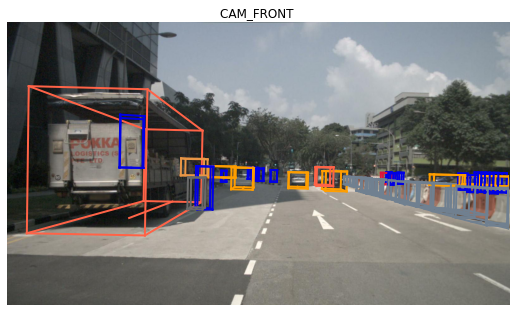

In [19]:

nusc.render_sample_data(cam_data['token'])

In [20]:
import cv2

In [21]:
def drawBoundingBox(imgcv,xmin,xmax,ymin,ymax):
  x1 = int(xmin)
  y1 = int(ymax)
  x2 = int(xmax)
  y2= int(ymin)
  #(x1,y1),(x2,y2) = (xmin,ymax),(xmax,ymin)

        
            # print(x1,y1,x2,y2,conf,label)
  cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,255,0),6)
  #labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.5,2)
            # print('labelSize>>',labelSize)
 # _x1 = x1
  #_y1 = y1#+int(labelSize[0][1]/2)
  #_x2 = _x1
  #_y2 = y1
  #cv2.rectangle(imgcv,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
  #cv2.putText(imgcv,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
  return imgcv 

In [31]:
cam_data = nusc.get('sample_data',my_sample['data']['CAM_FRONT'])
file_name = osp.join(nusc.dataroot,cam_data['filename']) 

In [117]:
xmin,ymin,xmax,ymax=(annotations['bboxes'][8,:])

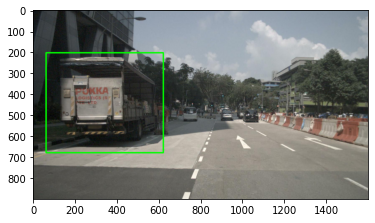

In [118]:
 image= plt.imread(file_name)
 image = cv2.UMat(image).get()
 
 bx = drawBoundingBox(image,xmin,xmax,ymin,ymax)
 plt.imshow(bx)

# **RADAR CHANNEL FORMATION**




In [33]:
radar_token =my_sample['data']['RADAR_FRONT']
camera_token = my_sample['data'] ['CAM_FRONT']
def load_sample_data(sample,sensor_channel):
  sd_rec = nusc.get('sample_data',sample['data'][sensor_channel])
  file_name = osp.join(nusc.dataroot,sd_rec['filename']) 
  if 'CAM' in sensor_channel:
    i = Image.open(file_name)
    data = np.array(i)
  elif 'RADAR' in sensor_channel:
  
    pc = RadarPointCloud.from_file(file_name) 
    data = pc.points.astype(float)
    data = enrich_radar_data(data)
  else:
    pass
  return data    

In [34]:
data = load_sample_data(my_sample,'RADAR_FRONT')

*****For Noisy Image

In [35]:
def noisy(noise_typ, image, noise_factor):
    """
    image : ndarray Input image data. Will be converted to float.
    noise_typ : str
    One of the following strings, selecting the type of noise to add:
    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    """
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = noise_factor
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p-perchannel":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = noise_factor
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "s&p-perpixel":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = noise_factor
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.shape[0] * image.shape[1] * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape[0:2]]
        out[tuple(coords)] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.shape[0] * image.shape[1]  * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape[0:2]]
        out[tuple(coords)] = 0
        return out
    elif noise_typ == "poisson":
        if noise_factor == 0:
            return image
        vals = len(np.unique(image)) / noise_factor
        vals = 2 ** np.ceil(np.log2(vals)) 
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)
        noisy = image + image * gauss
        return noisy
    elif noise_typ =="blur":
        noise_factor = int(noise_factor)
        return cv2.GaussianBlur(image,(noise_factor,noise_factor),0)

End*********

***MAP_POINT_CLOUD_FUNCTION ,Resize,Radar_transformation





In [231]:
def map_pointcloud_to_image(nusc, radar_points, pointsensor_token, camera_token, target_resolution=(None,None)):
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
    plane.
    :param radar_pints: [list] list of radar points
    :param pointsensor_token: [str] Lidar/radar sample_data token.
    :param camera_token: [str] Camera sample_data token.
    :param target_resolution: [tuple of int] determining the output size for the radar_image. None for no change
    :return (points <np.float: 2, n)
    """

    # Initialize the database
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    radar_points = np.array(radar_points)
   
    pc = RadarPointCloud(radar_points)

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    

    # intrinsic_resized = np.matmul(camera_resize, np.array(cs_record['camera_intrinsic']))
    view = np.array(cs_record['camera_intrinsic'])
    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    xyz_cord = np.zeros((3,len(pcs.points[0])))
    for i in range(3):
      
      xyz_cord[i,:] = np.asarray(pc.points[i])


    points = view_points(xyz_cord, view, normalize=True) #resize here
     
    
    #for i in range(3):
         #points[i]= xyz_cord[i]


    # Resizing to target resolution
    if target_resolution[1]: # resizing width
        points[0,:] *= (target_resolution[1]/cam['width'])

    if target_resolution[0]: # resizing height
        points[1,:] *= (target_resolution[0]/cam['height'])
   

    # actual_resolution = (cam['height'], cam['width'])
    # for i in range(len(target_resolution)):
    #     if target_resolution[i]:
    #         points[i,:] *= (target_resolution[i]/actual_resolution[i])
    radar_point = enrich_radar_data(pc.points)
    radar_point[0:3] = points

    return radar_point

In [37]:
def _resize_image(image_data, target_shape):
    """
    Perfomrs resizing of the image and calculates a matrix to adapt the intrinsic camera matrix
    :param image_data: [np.array] with shape (height x width x 3)
    :param target_shape: [tuple] with (width, height)
    :return resized image: [np.array] with shape (height x width x 3)
    :return resize matrix: [numpy array (3 x 3)]
    """
    # print('resized', type(image_data))
    stupid_confusing_cv2_size_because_width_and_height_are_in_wrong_order = (target_shape[1], target_shape[0])
    resized_image = cv2.resize(image_data, stupid_confusing_cv2_size_because_width_and_height_are_in_wrong_order)
    resize_matrix = np.eye(3, dtype=resized_image.dtype)
    resize_matrix[1, 1] = target_shape[0]/image_data.shape[0]
    resize_matrix[0, 0] = target_shape[1]/image_data.shape[1]
    return resized_image, resize_matrix


def _radar_transformation(radar_data, height=None):
    """
    Transforms the given radar data with height z = 0 and another height as input using extrinsic radar matrix to vehicle's co-sy
    This function appends the distance to the radar point.
    Parameters:
    :param radar_data: [numpy array] with radar parameter (e.g. velocity) in rows and radar points for one timestep in columns
        Semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 distance
    :param radar_extrinsic: [numpy array (3x4)] that consists of the extrinsic parameters of the given radar sensor
    :param height: [tuple] (min height, max height) that defines the (unknown) height of the radar points
    Returns:
    :returns radar_data: [numpy array (m x no of points)] that consists of the transformed radar points with z = 0
    :returns radar_xyz_endpoint: [numpy array (3 x no of points)] that consits of the transformed radar points z = height  
    """

    # Field of view (global)
    ELEVATION_FOV_SR = 20
    ELEVATION_FOV_FR = 14  

    # initialization
    num_points = radar_data.shape[1]

    # Radar points for the endpoint
    radar_xyz_endpoint = radar_data.copy()

    # variant 1: constant height substracted by RADAR_HEIGHT
    RADAR_HEIGHT = 0.5
    if height:
        radar_data[2, :] = np.ones((num_points,)) * (height[0] - RADAR_HEIGHT) # lower points
        radar_xyz_endpoint[2, :] = np.ones((num_points,)) * (height[1] - RADAR_HEIGHT) # upper points
    
    # variant 2: field of view
    else:
        dist = radar_data[-1,:]
        count = 0
        for d in dist:
            # short range mode
            if d <= 70: 
                radar_xyz_endpoint[2, count] = -d * np.tan(ELEVATION_FOV_SR/2)
                
            # long range mode
            else:
                radar_xyz_endpoint[2, count] = -d * np.tan(ELEVATION_FOV_FR/2)

            count += 1

    return radar_data, radar_xyz_endpoint    



##Radar_to_camera_functtion + _Create_vertical_line

In [188]:

def _create_vertical_line(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points
    :param P1: [numpy array] that consists of the coordinate of the first point (x,y)
    :param P2: [numpy array] that consists of the coordinate of the second point (x,y)
    :param img: [numpy array] the image being processed
    :return itbuffer: [numpy array] that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y])     
    """
    # define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]

    # difference and absolute difference between points
    # used to calculate slope and relative location between points
    P1_y = int(P1[1])
    P2_y = int(P2[1])
    dX = 0
    dY = P2_y - P1_y
    if dY == 0:
        dY = 1
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    # predefine numpy array for output based on distance between points
    itbuffer = np.empty(
        shape=(np.maximum(int(dYa), int(dXa)), 2), dtype=np.float32)
    itbuffer.fill(np.nan)

    # vertical line segment
    itbuffer[:, 0] = int(P1[0])
    if P1_y > P2_y:
        # Obtain coordinates along the line using a form of Bresenham's algorithm
        itbuffer[:, 1] = np.arange(P1_y - 1, P1_y - dYa - 1, -1)
    else:
        itbuffer[:, 1] = np.arange(P1_y+1, P1_y+dYa+1)

    # Remove points outside of image
    colX = itbuffer[:, 0].astype(int)
    colY = itbuffer[:, 1].astype(int)
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) &
                        (colX < imageW) & (colY < imageH)]

    return itbuffer





def _radar2camera(image_data, radar_data, radar_xyz_endpoints, clear_radar=False):
    """
    
    Calculates a line of two radar points and puts the radar_meta data as additonal layers to the image -> image_plus
    :param image_data: [numpy array (900 x 1600 x 3)] of image data
    :param radar_data: [numpy array (xyz+meta x no of points)] that consists of the transformed radar points with z = 0
        default semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 vx_rms vy_rms distance
    :param radar_xyz_endpoints: [numpy array (3 x no of points)] that consits of the transformed radar points z = height
    :param clear_radar: [boolean] True if radar data should be all zero
    :return image_plus: a numpy array (900 x 1600 x (3 + number of radar_meta (e.g. velocity)))
    """

    radar_meta_count = radar_data.shape[0]-3
    radar_extension = np.zeros(
        (image_data.shape[0], image_data.shape[1], radar_meta_count), dtype=np.float32)
    no_of_points = radar_data.shape[1]

    if clear_radar:
        pass # we just don't add it to the image
    else:
        for radar_point in range(0, no_of_points):
            projection_line = _create_vertical_line(
                radar_data[0:2, radar_point], radar_xyz_endpoints[0:2, radar_point], image_data)

            for pixel_point in range(0, projection_line.shape[0]):
                y = projection_line[pixel_point, 1].astype(int)
                x = projection_line[pixel_point, 0].astype(int)

                # Check if pixel is already filled with radar data and overwrite if distance is less than the existing
                if not np.any(radar_extension[y, x]) or radar_data[-1, radar_point] < radar_extension[y, x, -1]:
                    radar_extension[y, x] = radar_data[3:, radar_point]


    image_plus = np.concatenate((image_data, radar_extension), axis=2)

    return image_plus


*****Image_plus_creation function


In [233]:

def imageplus_creation(image_data, radar_data, radar_token, camera_token, height=(0,3),  \
        image_target_shape=(900, 1600), clear_radar=False, clear_image=False):
    barcode = False
    if height[1] > 20:
        height = (0,1)
        barcode = True
    enriched_data = enrich_radar_data(radar_data) 
    # Resize the image due to a target shape
    cur_img, camera_resize = _resize_image(image_data, image_target_shape)
    radar_points, radar_xyz_endpoint = _radar_transformation(enriched_data, height)
    radar_points= radar_points[0:18]
    radar_xyz_endpoint= radar_xyz_endpoint[0:18]
    

    #print(len(radar_xyz_endpoint))
    if clear_image: 
        cur_img.fill(0)
    radar_points = map_pointcloud_to_image(nusc, radar_points, radar_token, camera_token=camera_token, target_resolution=image_target_shape)
    radar_xyz_endpoint = map_pointcloud_to_image(nusc, radar_xyz_endpoint, radar_token, camera_token=camera_token, target_resolution=image_target_shape)
      
    if barcode:
        radar_points[1,:] = image_data.shape[0]
        radar_xyz_endpoint[1,:] = 0
    
    image_plus = _radar2camera(cur_img, radar_points, radar_xyz_endpoint, clear_radar=clear_radar)
        

    return image_plus
    
  

In [239]:
def load_image(sample_token,noisy_image_method=None,noise_factor=0,image_pluse_enabled=False):

  ###Add radar_channel
  
  sample = nusc.get('sample',sample_token)
  radar_token = sample['data']['RADAR_FRONT']
  camera_token = sample['data']['CAM_FRONT']
  image_sample = load_sample_data(sample,'CAM_FRONT')
  radar_sample_enrich = load_sample_data(sample,'RADAR_FRONT')
  sd_rec = nusc.get('sample_data',sample['data']['RADAR_FRONT'])
  file_name = osp.join(nusc.dataroot,sd_rec['filename']) 
  pcs = RadarPointCloud.from_file(file_name) 
  radar_data = pcs.points.astype(float)
  radar_data = np.array(radar_data)
 
   
  

  sensor_channel= 'RADAR_FRONT'
  required_sweep_count = 50
  #pcs, times = RadarPointCloud.from_file_multisweep(nusc, sample, sensor_channel, \
                #sensor_channel, nsweeps=required_sweep_count, min_distance=0.0)
  
  if noisy_image_method is not None and noise_factor> 0:
    image_sample = noisy(noisy_image_method,noise_factor)

  if image_pluse_enabled :
    pass

  img_p_full =imageplus_creation(image_sample,radar_data,radar_token,camera_token)  
   
  input_data = img_p_full[:,:,:] 

  return input_data
  



In [240]:

image_plus_data= load_image(my_scene['first_sample_token'])


##Visulization of Radar Image

In [253]:

# 3rd Party Libraries
import numpy as np

# Constants
MINIMAL_STD = 0.1

# Local Libraries
channel_map = {
    0: 'x',
    1: 'y',
    2: 'z',
    3: 'dyn_prop',
    4: 'id',
    5: 'rcs',
    6: 'vx',
    7: 'vy',
    8: 'vx_comp',
    9: 'vy_comp',
    10: 'is_quality_valid',
    11: 'ambig_state',
    12: 'x_rms',
    13: 'y_rms',
    14: 'invalid_state',
    15: 'pdh0',
    16: 'vx_rms',
    17: 'vy_rms',
    18: 'distance',
    19: 'azimuth',
    20: 'vrad_comp'
 }

mean_map =  {
    'ambig_state': 3.0,
    'azimuth' : 0.0,
    'distance': 53.248833,
    'dyn_prop': 1.6733711,
    'id': 50.728333,
    'invalid_state': 0.0,
    'is_quality_valid': 1.0,
    'pdh0': 1.0315487,
    'rcs': 8.17769,
    'vrad_comp' : 0.0,
    'vx': 1.3686545,
    'vx_comp': -0.022377603,
    'vx_rms': 16.305613,
    'vy': 0.049794517,
    'vy_comp': -0.009300133,
    'vy_rms': 3.0,
    'x': 49.94819,
    'x_rms': 19.530258,
    'y': 0.0,
    'y_rms': 19.876368,
    'z': 0.0,
 }


std_map = {
    'ambig_state': 2.3841858e-07,
    'azimuth' : 0.41397777,
    'distance': 36.195225,
    'dyn_prop': 1.3584259,
    'id': 35.54741,
    'invalid_state': 0.0,
    'is_quality_valid': 0.0,
    'pdh0': 0.24920322,
    'rcs': 7.5784483,
    'vrad_comp' : 1.9210424,
    'vx': 6.286945,
    'vx_comp': 1.4791956,
    'vx_rms': 0.5934909,
    'vy': 4.8759995,
    'vy_comp': 0.37958348,
    'vy_rms': 2.3841858e-07,
    'x': 36.01416,
    'x_rms': 0.796998,
    'y': 18.806744,
    'y_rms': 1.2855062,
    'z': 0.0,
 } 

normalizing_mask = {
    'ambig_state': True,
    'dyn_prop': True,
    'id': False,
    'invalid_state': True,
    'is_quality_valid': True,
    'pdh0': True,
    'rcs': True,
    'vx': True,
    'vx_comp': True,
    'vx_rms': True,
    'vy': True,
    'vy_comp': True,
    'vy_rms': True,
    'x': True,
    'x_rms': True,
    'y': True,
    'y_rms': True,
    'z': True,
    'distance' : True,
    'azimuth' : True,
    'vrad_comp' : True
 }

# mapping from name to id
channel_map_inverted = {v:k for k,v in channel_map.items()}


def normalize(channel, value, normalization_interval=(-1,1), sigma_factor=1):
    """
    :param channel: the radar channel of the corresponding radar_channel map
    :param value: <float or numpy.array> the value to normalize
    :param sigma_factor: multiples of sigma used for normalizing the value
    :returns: the normalized channel values
    """
    if isinstance(channel, int):
        # convert channel integer into string
        channel = channel_map[channel]

    if normalizing_mask[channel]:
        std = max(std_map[channel], MINIMAL_STD) # we do not want to divide by 0
        normalized_value = (value - mean_map[channel]) / (std*sigma_factor) # standardize to [-1, 1]
        normalized_value = ((normalized_value + 1) / 2) # standardize to [0, 1]
        normalized_value = (normalized_value * (normalization_interval[1] - normalization_interval[0])) + normalization_interval[0] # normalization interval
        return normalized_value
    else:
        # The value is ignored by the normalizing mask
        return value


def denormalize(channel, value, normalization_interval=(-1,1), sigma_factor=1):
    """
    :param channel: the radar channel of the corresponding radar_channel map
    :param value: <float or numpy.array> the value to normalize
    :param sigma_factor: multiples of sigma used for normalizing the value
    :returns: the normalized channel values
    """
    if isinstance(channel, int):
        # convert channel integer into string
        channel = channel_map[channel]

    if normalizing_mask[channel]:
        std = max(std_map[channel],MINIMAL_STD)

        denormalized_value = (value - normalization_interval[0]) / (normalization_interval[1] - normalization_interval[0]) # [0,1]
        denormalized_value = ((denormalized_value * 2) -1) # standardize to [-1, 1]
        denormalized_value = denormalized_value* (std*sigma_factor) + mean_map[channel]
        return denormalized_value
    else:
        # The value is ignored by the normalizing mask
        return value

def filter_radar_byDist(radar_data, distance):
    """
    :param radar_data: axis0 is channels, axis1 is points
    :param distance: [float] -1 for no distance filtering
    """
    if distance > 0:
        no_of_points = radar_data.shape[1]
        deleter = 0
        for point in range(0, no_of_points):
            dist = np.sqrt(radar_data[0,point - deleter]**2 + radar_data[1,point - deleter]**2)
            if dist > distance:
                radar_data = np.delete(radar_data, point - deleter, 1) 
                deleter += 1
    
    return radar_data

def calculate_distances(radar_data):
    """
    :param radar_data: axis0 is channels, axis1 is points
    """
    dist = np.sqrt(radar_data[0,:]**2 + radar_data[1,:]**2)
    return dist




In [344]:
def create_imagep_visualization(image_plus_data, color_channel="distance", \
        draw_circles=False, cfg=None, radar_lines_opacity=1.0):
    """
    Visualization of image plus data
    Parameters:
        :image_plus_data: a numpy array (900 x 1600 x (3 + number of radar_meta (e.g. velocity)))
        :image_data: a numpy array (900 x 1600 x 3)
        :color_channel: <str> Image plus channel for colorizing the radar lines. according to radar.channel_map.
        :draw_circles: Draws circles at the bottom of the radar lines
    Returns:
        :image_data: a numpy array (900 x 1600 x 3)
    """
    # read dimensions
    image_plus_height = image_plus_data.shape[0]
    image_plus_width = image_plus_data.shape[1]
    n_channels = image_plus_data.shape[2]

    ##### Extract the image Channels #####
    if cfg is None:
        image_channels = [0,1,2]
    else:
        image_channels = [i_ch for i_ch in cfg.channels if i_ch in [0,1,2]]
       
    image_data = np.ones(shape=(*image_plus_data.shape[:2],3))
   
    if len(image_channels) > 0:
        image_data[:,:,image_channels] = image_plus_data[:,:,image_channels].copy() # copy so we dont change the old image

    # Draw the Horizon
    image_data = np.array(image_data).astype(np.uint8)
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)

    ##### Paint every augmented pixel on the image #####
    if n_channels > 3:
        # transfer it to the currently selected channels
        if cfg is None:
            print("Warning, no cfg provided. Thus, its not possible to find out \
                which channel shall be used for colorization")
            radar_img = np.zeros(image_plus_data.shape[:-1]) # we expect the channel index to be the last axis
        else:
            available_channels = {channel_map[ch]:ch_idx for ch_idx, ch in enumerate(cfg.channels) if ch > 2}
            ch_idx = available_channels[color_channel]
            # Normalize the radar
            if cfg.normalize_radar: # normalization happens from -127 to 127
                radar_img = image_plus_data[...,ch_idx] + 127.5
            else:
                radar_img = normalize(color_channel, image_plus_data[..., ch_idx],
                                            normalization_interval=[0, 255], sigma_factor=2)

            radar_img = np.clip(radar_img,0,255)

        radar_colormap = np.array(cv2.applyColorMap(radar_img.astype(np.uint8), cv2.COLORMAP_AUTUMN))

        for x in range(0, image_plus_width):
            for y in range(0, image_plus_height):
                radar_channels = image_plus_data[y, x, 3:]
                pixel_contains_radar = np.count_nonzero(radar_channels)
                if not pixel_contains_radar:
                    continue

                radar_color = radar_colormap[y,x]
                for pixel in [(y,x)]: #[(y,x-1),(y,x),(y,x+1)]:
                    if image_data.shape > pixel:
                                
                        # Calculate the color
                        pixel_color = np.array(image_data[pixel][0:3], dtype=np.uint8)
                        pixel_color = np.squeeze(cv2.addWeighted(pixel_color, 1-radar_lines_opacity, radar_color, radar_lines_opacity, 0))

                        # Draw on image
                        image_data[pixel] = pixel_color
                    
                # only if some radar information is there
                if draw_circles:
                    if image_plus_data.shape[0] > y+1 and not np.any(image_plus_data[y+1, x,3:]):
                        cv2.circle(image_data, (x,y), 3, color=radar_colormap[(y,x)].astype(np.float), thickness=1)


    return image_data


In [345]:
class cfg():
  def __init__(self,channels,normalize_radar=False):
    self.channels = channels
    self.normalize_radar = normalize_radar


cfg = cfg([0,1,2,18])

img_vis = create_imagep_visualization(image_plus_data, color_channel="distance",cfg =cfg)

img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)
img_vis = np.array(img_vis,dtype =int)


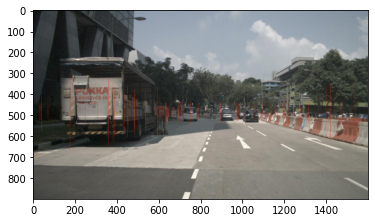

In [346]:
plt.imshow(img_vis)

In [326]:
img_vis[:,:,0]

array([[225, 226, 226, ..., 132, 132, 132],
       [226, 226, 225, ..., 132, 132, 132],
       [231, 230, 230, ..., 132, 132, 132],
       ...,
       [230, 194, 189, ..., 154, 153, 153],
       [230, 194, 189, ..., 155, 155, 154],
       [230, 194, 189, ..., 156, 155, 155]])

In [310]:
x[:,:,2]

array([[ 25,  26,  26, ..., 151, 151, 151],
       [ 24,  24,  27, ..., 151, 151, 151],
       [ 17,  20,  22, ..., 151, 151, 151],
       ...,
       [ 26,  62,  67, ...,  94,  95,  95],
       [ 26,  62,  67, ...,  93,  93,  94],
       [ 26,  62,  67, ...,  92,  93,  93]], dtype=uint8)

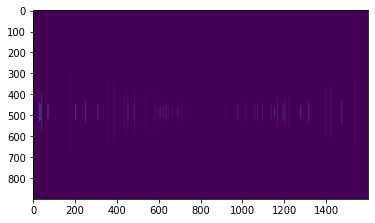

In [323]:
plt.imshow(img[:,:,18])

In [314]:
img = (image_plus_data[:,:,:])
img = np.array(img,dtype=int)
#plt.imshow(img)

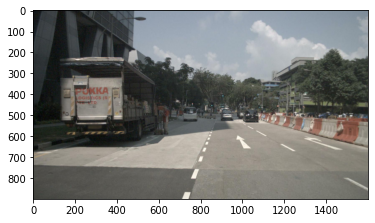

In [298]:
cam_data = nusc.get('sample_data',my_sample['data']['CAM_FRONT'])
file_name = osp.join(nusc.dataroot,cam_data['filename']) 
x =plt.imread(file_name)
plt.imshow(x[:,:,0:3])

In [146]:
radar_token  = my_sample['data']['RADAR_FRONT'
]
radar_sample = nusc.get('sample_data',radar_token)
file_name_radar = osp.join(nusc.dataroot,radar_sample['filename'])

pcs = RadarPointCloud.from_file(file_name_radar) 

21

In [176]:
en[0:2,63]

array([ 59.        , -22.10000038])

In [162]:
x=[]
x=en[0:18]

In [163]:
x.shape[0]

18